In [36]:
from absl import logging

#import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow_hub as hub

In [91]:
def download_and_resize(path, new_width=256, new_height=256):
    image = Image.open(path)
    if np.array(image).shape[2] != 3:
        image = image.convert('RGB')
    image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
    return image

def run_delf(image):
    delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']
    np_image = np.array(image)
    float_image = tf.image.convert_image_dtype(np_image, tf.float32)
    print(float_image.shape)
    

    return delf(
      image=float_image,
      score_threshold=tf.constant(90.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

In [120]:
image1 = download_and_resize("test3.png")
image2 = download_and_resize('test4.jpg')

In [121]:
result1 = run_delf(image1)
result2 = run_delf(image2)

(256, 256, 3)
(256, 256, 3)


In [122]:
distance_threshold = 0.95
# Read features.
num_features_1 = result1['locations'].shape[0]
#print("Loaded image 1's %d features" % num_features_1)    
num_features_2 = result2['locations'].shape[0]
#print("Loaded image 2's %d features" % num_features_2)

# Find nearest-neighbor matches using a KD tree.
d1_tree = cKDTree(result1['descriptors'])
_, indices = d1_tree.query(
    result2['descriptors'],
    distance_upper_bound=distance_threshold
)

In [123]:
# Select feature locations for putative matches.
locations_2_to_use = np.array([
    result2['locations'][i,]
    for i in range(num_features_2)
    if indices[i] != num_features_1
])
locations_1_to_use = np.array([
    result1['locations'][indices[i],]
    for i in range(num_features_2)
    if indices[i] != num_features_1
])

if (len(locations_2_to_use) or (len(locations_1_to_use))) == 0:
        print('Found 0 inliers')

In [124]:
if (len(locations_2_to_use) or (len(locations_1_to_use))) == 0:
        print('Found 0 inliers')
else:
# Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    
print(sum(inliers))

6


Text(0.5, 1.0, 'DELF correspondences')

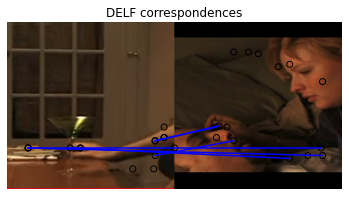

In [125]:
# Visualize correspondences.
_, ax = plt.subplots()
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')

In [126]:
from PIL import Image
import imagehash
hash0 = imagehash.average_hash(Image.open('test3.png')) 
hash1 = imagehash.average_hash(Image.open('test4.jpg')) 
cutoff = 30  # maximum bits that could be different between the hashes. 

if hash0 - hash1 < cutoff:
  print('images are similar')
else:
  print('images are not similar')

images are not similar


In [10]:
import os

movies = "honey"
location_path = f"/media/lkunam/DVU-Challenge/HLVU/movie_knowledge_graph/{movies}/image/Location"

for location in os.listdir(location_path):
    for loc_image in os.listdir(f"{location_path}/{location}"):
        print(loc_image)
        break
    break

Home1_7.png
